In [32]:
import torch 
import torch.nn as nn
import lightning as L

import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split

from BalticRiverPrediction.BaltNet import BaltNet
from BalticRiverPrediction.BaltNet import LightningModel
from BalticRiverPrediction.BaltNet import AtmosphereDataModule, AtmosphericDataset
from BalticRiverPrediction.sharedUtilities import read_netcdfs, preprocess

In [33]:
# Our GPU has tensor cores, hence mixed precision training is enabled
# see https://sebastianraschka.com/blog/2023/llm-mixed-precision-copy.html
# for more

torch.set_float32_matmul_precision("medium")

In [34]:
# set random seed for reproducibility
L.pytorch.seed_everything(123)

Global seed set to 123


123

Under `data/` one subdirectory stores the atmospheric data, the other the runoff data. The function `read_netcdfs` concatenated the data. For the precipitation the date is concatenated along the time axis, for the runoff along a new dimension called `river`.

In [35]:
datapath="/silor/boergel/paper/runoff_prediction/data"

data_rain = read_netcdfs(
    files=f"{datapath}/atmosphericForcing/????/rain.mom.dta.nc",
    dim="time",
    transform_func=lambda ds:preprocess(ds)
    )       


  0%|          | 0/54 [00:00<?, ?it/s]

100%|██████████| 54/54 [00:50<00:00,  1.06it/s]


In [ ]:
data_rain = read_netcdfs(
    files=f"{datapath}/atmosphericForcing/????/shumi.mom.dta.nc",
    dim="time",
    transform_func=lambda ds:preprocess(ds)
    )       

In [62]:
runoff = read_netcdfs(
    f"{datapath}/runoffData/combined_fastriver_*.nc",
    dim="river",
    transform_func= lambda ds:ds.sel(time=slice(str(2011), str(2014))).roflux.resample(time="1D").mean(),
    cftime=False
    )  

100%|██████████| 97/97 [00:28<00:00,  3.37it/s]


Config defines the setup of the model and the input data it expects. This will also affect the dataLoader. DataLoader automatically create batches of data and also put the data onto the GPU efficiently.

In [37]:
config = {
    "input_dim":32, # timesteps
    "hidden_dim":1, # Channels -> right now only precipitation
    "kernel_size":(7,7), # applied for spatial convolutions
    "num_layers":4, # number of convLSTM layers
    "batch_first":True, # first index is batch
    "bias":True, 
    "return_all_layers": False, 
    "dimensions": (191, 206) # dimensions of atmospheric forcing
}

In [38]:
# initalize model
pyTorchBaltNet = BaltNet(modelPar=config)

# Lightning model wrapper
LighningBaltNet = LightningModel(
    pyTorchBaltNet,
    learning_rate=1e-3,
    cosine_t_max=50
)

Here we load the best model version that was trained previously. Note, that best in this context means that the `val_mse` was minimized.

In [39]:
LighningBaltNet = LightningModel.load_from_checkpoint(
    checkpoint_path="/silor/boergel/paper/runoff_prediction/data/modelWeights/BaltNetTopOne-v4.ckpt",
    learning_rate=1e-3,
    model=pyTorchBaltNet
)

In [51]:
class AtmosphericDataset(Dataset):
    def __init__(self, input_size, data, runoff, transform=None):

        self.input_size = input_size

        runoffData = runoff.transpose("time", "river")
        runoffDataMean = runoffData.mean("time")
        runoffDataSTD = runoffData.std("time")

        rainData = data["RAIN"]
        rainDataMean = rainData.mean("time")
        rainDataSTD = rainData.std("time")

        self.rainData = (rainDataMean, rainDataSTD)
        self.runoffData = (runoffDataMean, runoffDataSTD)

        X = (rainData - rainDataMean)/rainDataSTD
        y = (runoffData - runoffDataMean)/runoffDataSTD

        # TODO 
        # add dummy dimension in only one atmospheric data file
        # is loaded
        
        X = ((rainData - rainDataMean) / rainDataSTD).compute()
        y = ((runoffData - runoffDataMean) / runoffDataSTD).compute()

        X = torch.tensor(X.data, dtype=torch.float32).unsqueeze(dim=0)
        self.x = X
        self.y = torch.tensor(y.data, dtype=torch.float32)

    def __getitem__(self, index):
        return self.x[:, index:index+(self.input_size)], self.y[index+int(self.input_size)]

    def __len__(self):
        return self.y.shape[0]-(self.input_size)

In [63]:
data = AtmosphericDataset(
    data=data_rain.sel(time=slice(str(2011), str(2014))),
    runoff=runoff,
    input_size=config["input_dim"],
)

In [64]:
predict_dataloader = DataLoader(
    data,
    batch_size=32,
    shuffle=False,
    drop_last=True
    )

In [65]:
trainer = L.Trainer(
    inference_mode=True,
    accelerator="cuda",
    devices=1,
    deterministic=True,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [73]:
predictions = trainer.predict(LighningBaltNet, dataloaders=predict_dataloader)
concatenated_predictions = torch.cat(predictions, dim=0)
rescaledRunoffData = concatenated_predictions*data.runoffData[1].data+data.runoffData[0].data

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/silos/conda_packages/boergel/miniconda3_4.12.0/OS_15.4/conda_env/BaltNet/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [67]:
origianlRunoffData = runoff.transpose("time", "river")
origianlRunoffData = origianlRunoffData.resample(time="1D").mean()

In [68]:
rescaledRunoffDataDataset = xr.DataArray(
    data = rescaledRunoffData.data,
    coords={
        "time": origianlRunoffData.time[config["input_dim"]:],
        "river": origianlRunoffData.river
    }
)


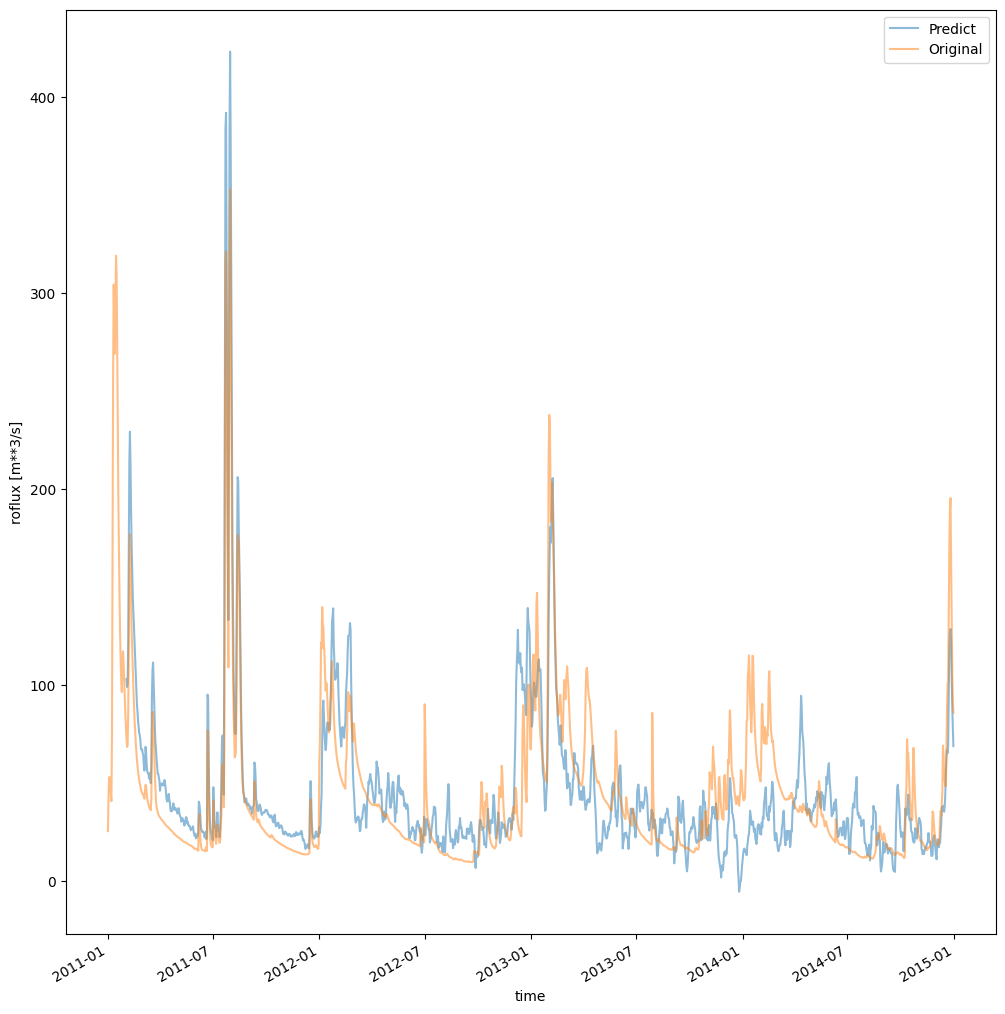

In [69]:
f, ax = plt.subplots(1, figsize=(12,12))
rescaledRunoffDataDataset.isel(river=1).plot(ax=ax, label = "Predict", alpha=.5)
origianlRunoffData.isel(river=1).plot(ax=ax, label="Original", alpha=0.5)
plt.legend()

In [76]:
rescaledRunoffDataDataset

<xarray.DataArray (time: 1429, river: 97)>
array([[ 4.63920762e+01,  1.03213846e+02,  2.59568903e+03, ...,
         9.12836802e+00,  2.11966965e+02, -1.36280106e+01],
       [ 4.50337411e+01,  9.91634384e+01,  2.42033746e+03, ...,
         6.16813018e-01,  2.05829161e+02, -1.32569297e+01],
       [ 4.62280818e+01,  1.00951973e+02,  2.25986768e+03, ...,
         2.42045503e+01,  2.27102428e+02, -1.51455033e+01],
       ...,
       [ 6.59084780e+01,  8.92586946e+01,  6.17021519e+02, ...,
         8.24440256e+01,  2.98945668e+02,  2.93208399e+01],
       [ 5.94736440e+01,  7.83692848e+01,  6.81758287e+02, ...,
         8.10493632e+01,  2.86913146e+02,  2.35338010e+01],
       [ 5.45178078e+01,  6.90432722e+01,  6.45854299e+02, ...,
         6.23675907e+01,  2.80461481e+02,  2.32871322e+01]])
Coordinates:
  * time     (time) datetime64[ns] 2011-02-02 2011-02-03 ... 2014-12-31
  * river    (river) int64 0 1 2 3 4 5 6 7 8 9 ... 87 88 89 90 91 92 93 94 95 96

In [79]:
origianlRunoffData.sel(time=slice(rescaledRunoffDataDataset.time.min(), None))

<xarray.DataArray 'roflux' (time: 1429, river: 97)>
array([[3.50542259e+01, 7.32063828e+01, 2.63178198e+03, ...,
        1.07947655e+02, 1.63418579e+02, 9.98796225e-01],
       [3.65523682e+01, 6.86135101e+01, 2.46052393e+03, ...,
        1.07248703e+02, 1.61516052e+02, 9.98803973e-01],
       [3.60539093e+01, 6.90143967e+01, 2.31063696e+03, ...,
        1.06549744e+02, 1.59814392e+02, 9.98803973e-01],
       ...,
       [5.95096436e+01, 1.07690109e+02, 8.14127808e+02, ...,
        1.68647781e+02, 4.88239166e+02, 5.44499512e+01],
       [5.67879639e+01, 9.24306946e+01, 7.70611389e+02, ...,
        1.66846329e+02, 4.85055817e+02, 5.18577156e+01],
       [6.36112251e+01, 8.60138016e+01, 7.30669617e+02, ...,
        1.64640472e+02, 4.82016998e+02, 4.92644806e+01]])
Coordinates:
  * time     (time) datetime64[ns] 2011-02-02 2011-02-03 ... 2014-12-31
Dimensions without coordinates: river
Attributes:
    units:    m**3/s
    basin:    Kattegat
    lon:      11.097068
    lat:      53.974945

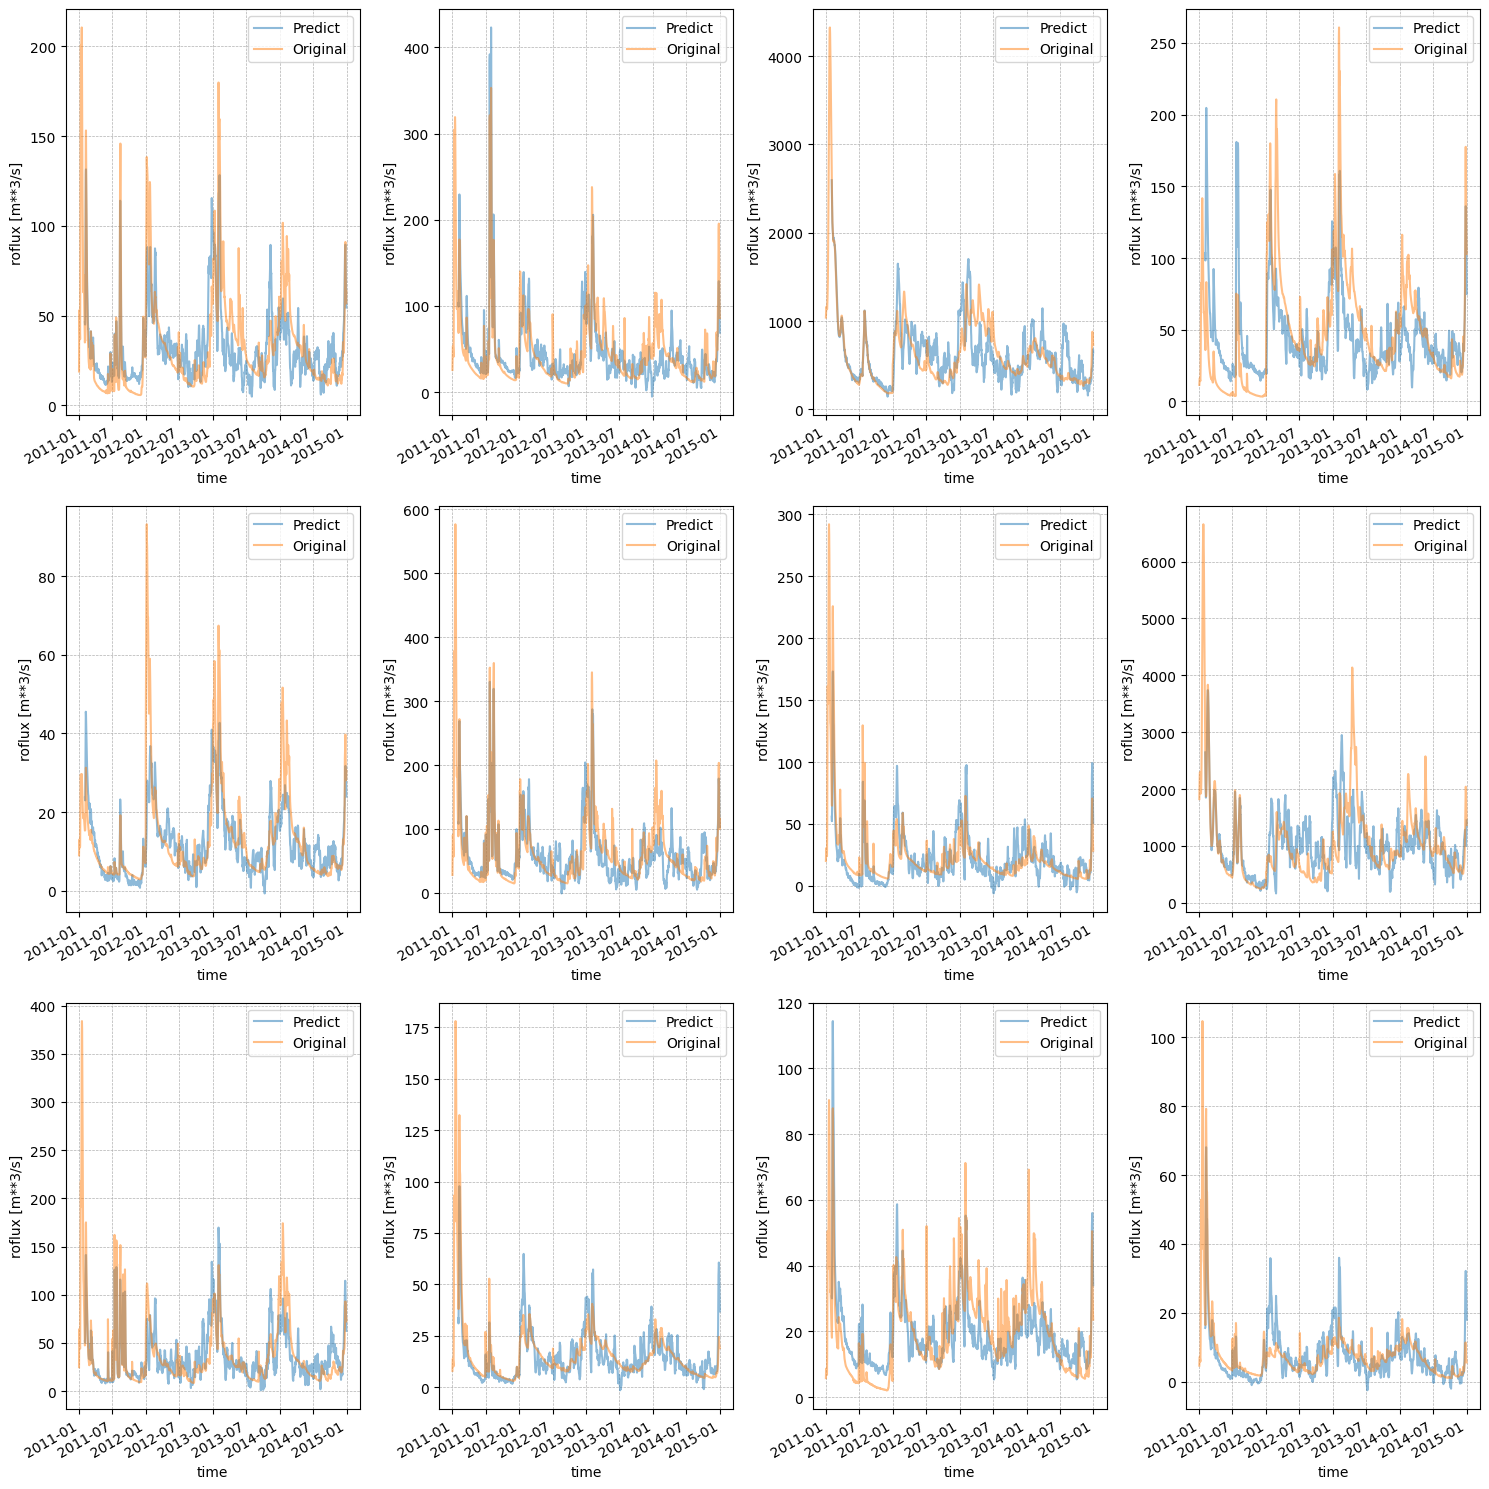

In [103]:
f, axs = plt.subplots(3,4, figsize=(15, 15))

for i, ax in enumerate(axs.ravel()):
    ax.set_title(f"River {i+1}")
    rescaledRunoffDataDataset.isel(river=i).plot(ax=ax, label = "Predict", alpha=.5)
    origianlRunoffData.isel(river=i).plot(ax=ax, label="Original", alpha=0.5)
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
plt.tight_layout()


In [74]:
class TaylorDiagram(object):
    """
    Taylor diagram.
    Plot model standard deviation and correlation to reference (data)
    sample in a single-quadrant polar plot, with r=stddev and
    theta=arccos(correlation).
    """
    def __init__(self, refdata, ax,  *args, **kwargs):
        # memorize reference data
        self.refdata = refdata
        self.ax = ax
        refstd = refdata.std(ddof=1) 
        rlim = [0.0, 1.2*refstd]
        thetalim = [0.0, 0.5*np.pi]
        if ax != None:
            # Add reference point and stddev contour
            try:
                kwargs["marker"]
            except:
                kwargs["marker"] = 'o'
            try:
                kwargs["color"]
            except:
                kwargs["color"] = "black"
            try:
                kwargs["ms"]
            except:
                kwargs["ms"] = 10     
            try:
                kwargs["label"]
            except:
                kwargs["label"] = "reference"                     
            ax.plot([0], refstd, *args, ls='', zorder=0, **kwargs)
            ax.grid(True, linestyle="--")
            
            ax.set_xlabel("St. dev.")
            ax.xaxis.set_label_coords(0.5, -0.1)
            ax.set_xlim(thetalim)
            ax.set_ylim(rlim)
            self.rlim = rlim
            self.thetalim = thetalim
        self.model_std = {"reference" : refstd}
        self.corrcoef = {"reference" : 1.0}
        self.rms = {"reference" : 0.0}
    def add_sample(self, model_data, *args, **kwargs):
        """
        Add sample to the Taylor
        diagram. *args* and *kwargs* are directly propagated to the
        `Figure.plot` command.
        """
        model_std = model_data.std(ddof=1)
        corrcoef = np.corrcoef(model_data, self.refdata)[0, 1]
        rms = np.sqrt(self.model_std["reference"]**2 + model_std**2 - 2.0*self.model_std["reference"]*model_std*np.cos(np.arccos(corrcoef)))
        try:
            label = kwargs["label"]
        except:
            label = "model"+str(len(self.model_std.keys())) 
        if self.ax != None:
            self.ax.plot(np.arccos(corrcoef), model_std,
                            *args, **kwargs)  # (theta, radius)
            if model_std > self.rlim[1]:
                self.rlim = [0, 1.2 * model_std]
                self.ax.set_ylim(*self.rlim)
            if np.arccos(corrcoef) > self.thetalim[1]:
                self.thetalim[1] = 1.2 * np.arccos(corrcoef)
                self.ax.set_xlim(*self.thetalim)                       
        self.model_std[label] = model_std
        self.corrcoef[label] = corrcoef
        self.rms[label] = rms
        #self.ax.set_ylim(rlim) 
    def get_samples(self):
        return self.model_std, self.corrcoef, self.rms
    def finalize(self):
        
        if self.ax is None:
            return 
        self.ax.text(0.5*(self.thetalim[1]-self.thetalim[0]), (1.0+0.03*(self.thetalim[1]-self.thetalim[0])**2)*self.rlim[1],"Correlation", rotation=0.5*(self.thetalim[1]-self.thetalim[0])*180.0/np.pi-90.0)
        rs, ts = np.meshgrid(np.linspace(*self.rlim), np.linspace(*self.thetalim))
        rms = np.sqrt(self.model_std["reference"]**2 + rs**2 - 2.0*self.model_std["reference"]*rs*np.cos(ts))
        self.ax.contourf(ts, rs, rms, 9, alpha=0.3, cmap="RdYlGn_r")
        contours = self.ax.contour(ts, rs, rms, 9, linestyles="--", linewidths=1, alpha=0.5, colors="grey")
        if self.model_std["reference"] > 100.0 or self.model_std["reference"] < 0.1:
            fmt = '%3.2e'
        else:
            fmt = '%3.2f'
        self.ax.clabel(contours, inline=False, fmt=fmt, colors="black")
        t = np.linspace(*self.thetalim)
        r = np.zeros_like(t) + self.model_std["reference"]
        self.ax.plot(t, r, 'k--', label='_')
        xticks = [1.0, 0.99, 0.95, 0.9, 0.8, 0.7, 0.6, 0.4, 0.2, 0.0]
        if self.thetalim[1] > 0.5*np.pi:
            for x in [-0.2, -0.4, -0.6, -0.8, -0.9, -0.95, -0.99 -1.0]:
                if np.arccos(x) > self.thetalim[1]:
                    break
                xticks += [x]
        self.ax.set_xticks(np.arccos(xticks))
        self.ax.set_xticklabels(xticks)

In [93]:
orignalTaylor = origianlRunoffData.sel(time=slice(rescaledRunoffDataDataset.time.min(), None)).isel(river=0)
modelPrediction = rescaledRunoffDataDataset.isel(river=0)

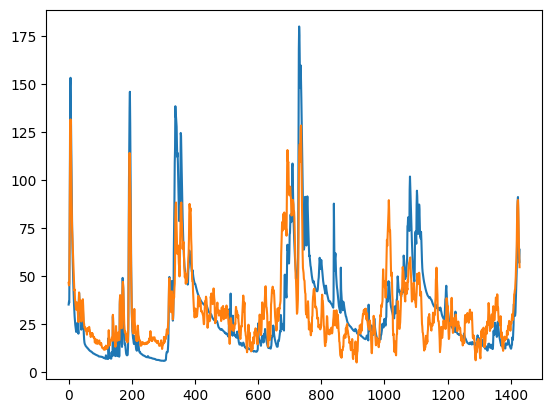

In [94]:
f, ax = plt.subplots(1)
ax.plot(orignalTaylor.data)
ax.plot(modelPrediction.data)

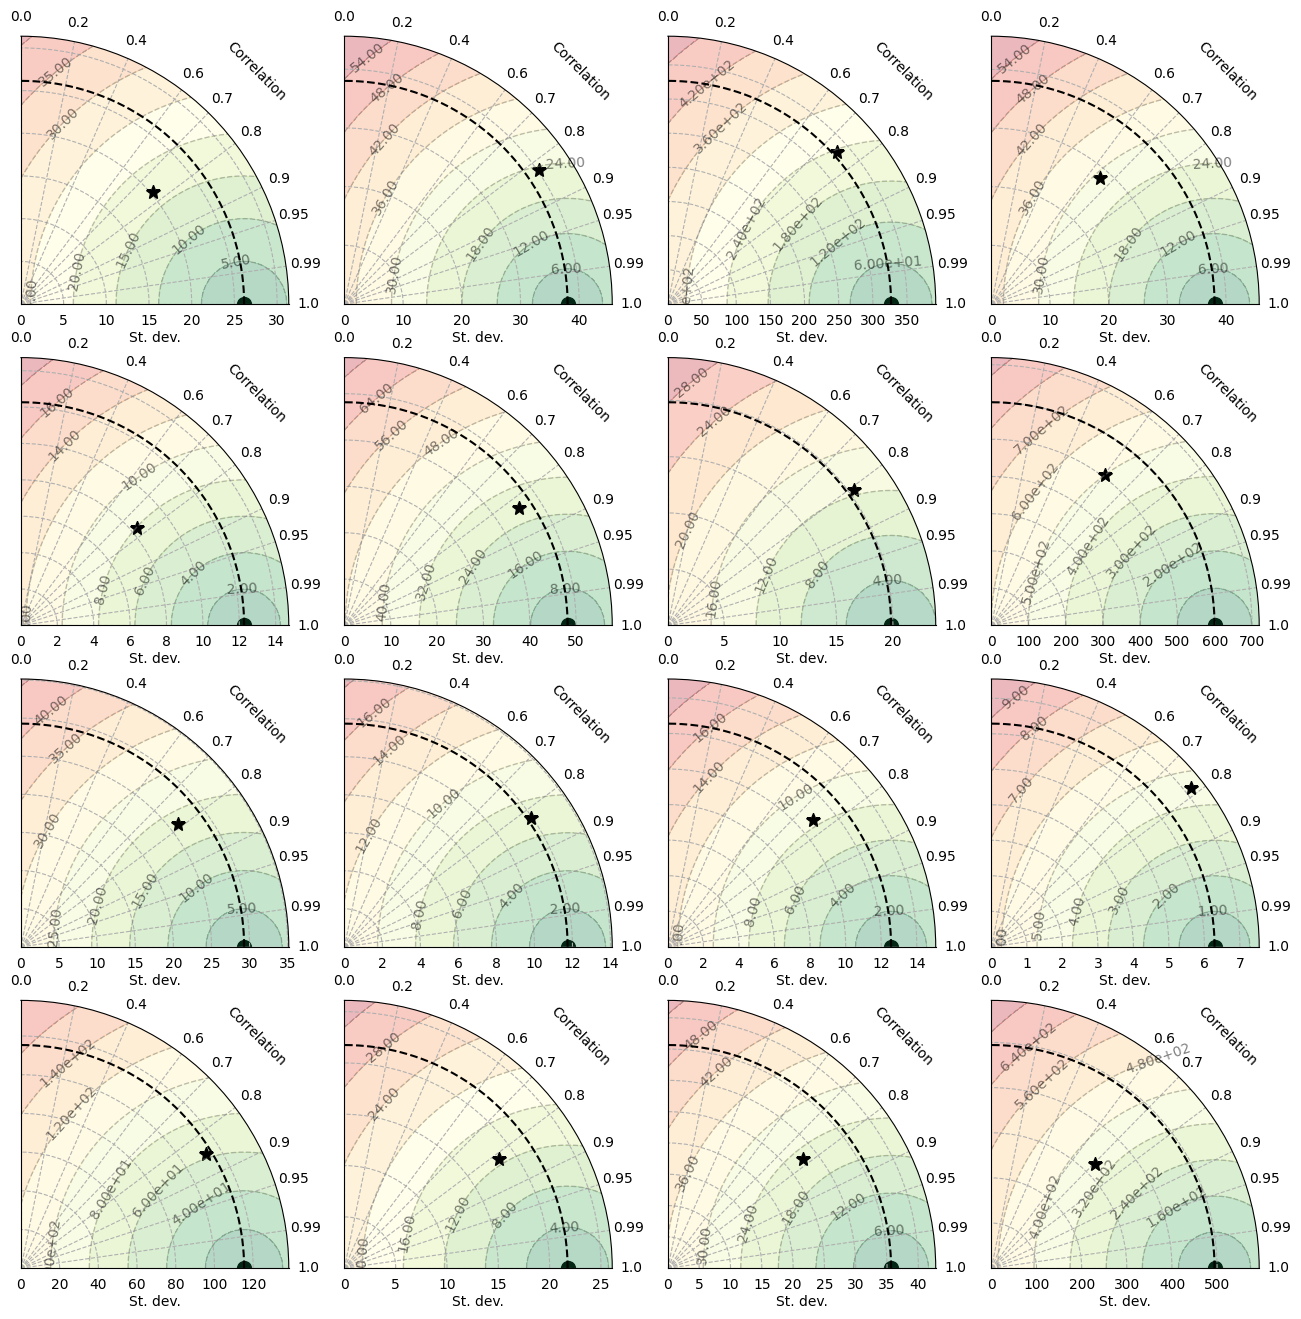

In [99]:
f, axes = plt.subplots(4,4, figsize=(16,16), subplot_kw={'projection': 'polar'})

for i,ax in enumerate(axes.ravel()):
    orignalTaylor = origianlRunoffData.sel(time=slice(rescaledRunoffDataDataset.time.min(), None)).isel(river=i)
    modelPrediction = rescaledRunoffDataDataset.isel(river=i)   
    diagram = TaylorDiagram(orignalTaylor.data, ax)
    diagram.add_sample(modelPrediction.data, marker='*', ms=10, ls='', color="black", label="River 0")
    diagram.finalize()
